In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as PLT
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.applications.resnet import ResNet152, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential, Model,Input
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D,ZeroPadding2D, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
import os,glob,random,shutil
from pathlib import Path
from tensorflow.keras.optimizers.legacy import Adam, SGD
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
import pickle

In [12]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[]


In [4]:
# Define required paths
data_path = 'Datasets/Scene/data'
train_test_path = 'Datasets/Scene/train_test'
train_path = 'Datasets/Scene/train_test/train'
test_path = 'Datasets/Scene/train_test/test'
model_path='Datasets/Scene/model'

In [5]:
# Create Train and Test set randomly per class in different directories
train_count = 100

if os.path.isdir(train_test_path):
    shutil.rmtree(train_test_path)
Path(f'{train_test_path}').mkdir(parents=True, exist_ok=True)

for category in os.listdir(data_path):
    images = glob.glob(f'{data_path}/{category}/*')
    random.shuffle(images)
    
    # Train data
    Path(f'{train_path}/{category}/').mkdir(parents=True, exist_ok=True)
    
    for img in images[:train_count]:
        shutil.copyfile(img, f'{train_path}/{category}/'+img.split("\\")[-1])
        
    # Test data
    Path(f'{test_path}/{category}/').mkdir(parents=True, exist_ok=True)
    for img in images[train_count:]:
        shutil.copyfile(img, f'{test_path}/{category}/'+img.split("\\")[-1])     

In [8]:
# Load the Training and Testing data
image_generator = ImageDataGenerator(
    rescale=1.0/255.0
)
batch_size = 15

generator = image_generator.flow_from_directory(
    train_path,
    class_mode='categorical',
    batch_size=batch_size,
    target_size=(150,150)
)

generator_test = image_generator.flow_from_directory(
    test_path,
    class_mode='categorical',
    batch_size=batch_size,
    target_size=(150,150)
)

Found 1500 images belonging to 15 classes.
Found 2995 images belonging to 15 classes.


 # Model1

In [9]:
# 5-layer CNN model1 with default learning rate (lr=0.001) and Adam optimizer

# Define the model1
model = Sequential([ 
    
    Conv2D(32, 3, strides=1, activation='relu', padding='same',input_shape=(150,150,3)),
    BatchNormalization(),
    MaxPool2D(pool_size=2),
    
    Conv2D(64, 3, strides=1, activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2),
    
    Conv2D(128, 3, strides=1, activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    
    Conv2D(256, 3, strides=1, activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2),
    
    Conv2D(512, 3, strides=1, activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2),
    
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.2),
    Dense(15, activation='softmax')
])

# Compile the model1
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
# Train the model1
history = model.fit(
    generator,
    validation_data=generator_test,
    epochs=20,
    batch_size=32
)

Epoch 1/20
100/100 [==============================] - 82s 815ms/step - loss: 2.7153 - accuracy: 0.2253 - val_loss: 3.8993 - val_accuracy: 0.0871
Epoch 2/20
100/100 [==============================] - 76s 759ms/step - loss: 2.0152 - accuracy: 0.3453 - val_loss: 6.0420 - val_accuracy: 0.0868
Epoch 3/20
100/100 [==============================] - 75s 755ms/step - loss: 1.7728 - accuracy: 0.4200 - val_loss: 4.9715 - val_accuracy: 0.0978
Epoch 4/20
100/100 [==============================] - 75s 753ms/step - loss: 1.5118 - accuracy: 0.5047 - val_loss: 3.5412 - val_accuracy: 0.2384
Epoch 5/20
100/100 [==============================] - 75s 752ms/step - loss: 1.2768 - accuracy: 0.5913 - val_loss: 3.8813 - val_accuracy: 0.2030
Epoch 6/20
100/100 [==============================] - 75s 755ms/step - loss: 1.1326 - accuracy: 0.6127 - val_loss: 2.4463 - val_accuracy: 0.3172
Epoch 7/20
100/100 [==============================] - 75s 751ms/step - loss: 0.9927 - accuracy: 0.6660 - val_loss: 4.2425 - val_ac

In [13]:
# Pickle the history object
with open('history.pickle', 'wb') as f:
    pickle.dump(history.history, f)
# Save the model1    
model.save('Scene/models/model1.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 150, 150, 32)      896       
                                                                 
 batch_normalization_5 (Batc  (None, 150, 150, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 73, 73, 64)        18496     
                                                                 
 batch_normalization_6 (Batc  (None, 73, 73, 64)       256       
 hNormalization)                                                 
                                                      

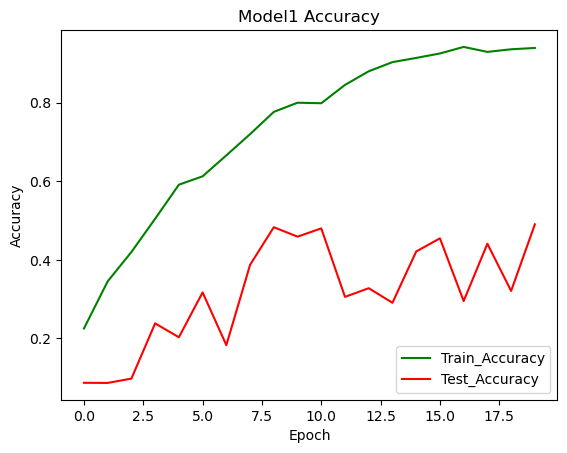

In [14]:
# Plot the model1
PLT.plot(history.history['accuracy'],color='green')
PLT.plot(history.history['val_accuracy'],color='red')
PLT.title('Model1 Accuracy')
PLT.ylabel('Accuracy')
PLT.xlabel('Epoch')
PLT.legend(['Train_Accuracy','Test_Accuracy'], loc='lower right')
PLT.show()

# Model2 

In [17]:
# 6-layer CNN model2 with default learning rate (lr=0.001) and Adam optimizer

# Define the model2
model = Sequential([
  
    Conv2D(32, 3, strides=1, activation='relu', padding='same',input_shape=(150,150,3)),
    Conv2D(32, 3, strides=1, activation='relu', padding='same'), 
    MaxPool2D(pool_size=2),
    BatchNormalization(),
    Dropout(0.2),
    
    Conv2D(64, 3, strides=1, activation='relu'),
    Conv2D(64, 3, strides=1, activation='relu'),
    MaxPool2D(pool_size=2),
    BatchNormalization(),
    Dropout(0.2),
       
    Conv2D(64, 3, strides=1, activation='relu'),
    Conv2D(64, 3, strides=1, activation='relu'),
    MaxPool2D(pool_size=2),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    
    Flatten(),
    Dense(15, activation='softmax')
])

# Compile the model2
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
# Train the model2
history1 = model.fit(
    generator,
    validation_data=generator_test,
    epochs=20,
    batch_size=32
)

Epoch 1/20
100/100 [==============================] - 66s 653ms/step - loss: 3.7685 - accuracy: 0.1087 - val_loss: 2.9282 - val_accuracy: 0.0868
Epoch 2/20
100/100 [==============================] - 64s 641ms/step - loss: 2.2706 - accuracy: 0.2720 - val_loss: 2.6256 - val_accuracy: 0.0868
Epoch 3/20
100/100 [==============================] - 63s 633ms/step - loss: 1.9897 - accuracy: 0.3620 - val_loss: 2.2222 - val_accuracy: 0.2805
Epoch 4/20
100/100 [==============================] - 64s 637ms/step - loss: 1.7353 - accuracy: 0.4493 - val_loss: 2.0590 - val_accuracy: 0.3242
Epoch 5/20
100/100 [==============================] - 63s 636ms/step - loss: 1.4895 - accuracy: 0.5093 - val_loss: 2.4585 - val_accuracy: 0.3275
Epoch 6/20
100/100 [==============================] - 312s 3s/step - loss: 1.2886 - accuracy: 0.5633 - val_loss: 1.8880 - val_accuracy: 0.4327
Epoch 7/20
100/100 [==============================] - 64s 646ms/step - loss: 1.0741 - accuracy: 0.6433 - val_loss: 2.3388 - val_accu

In [19]:
# Pickle the history object
with open('history1.pickle', 'wb') as f:
    pickle.dump(history1.history, f)
# Save the model2
model.save('Scene/models/model2.h5')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 150, 150, 32)      896       
                                                                 
 conv2d_17 (Conv2D)          (None, 150, 150, 32)      9248      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_13 (Bat  (None, 75, 75, 32)       128       
 chNormalization)                                                
                                                                 
 dropout_7 (Dropout)         (None, 75, 75, 32)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 73, 73, 64)       

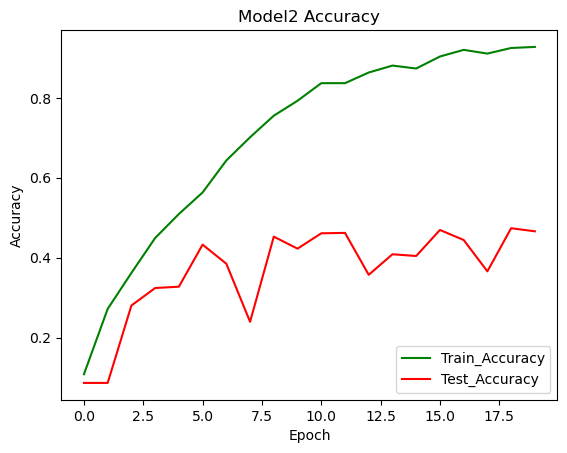

In [20]:
# Plot the model2
PLT.plot(history1.history['accuracy'],color='green')
PLT.plot(history1.history['val_accuracy'],color='red')
PLT.title('Model2 Accuracy')
PLT.ylabel('Accuracy')
PLT.xlabel('Epoch')
PLT.legend(['Train_Accuracy','Test_Accuracy'], loc='lower right')
PLT.show()

# Model3

In [76]:
## 5-layer CNN model3 with different learning rates for different convolutional layers and Adam optimizer

# Define the learning rate schedule
boundaries = [5, 10, 15, 20] # Epochs at which to change the learning rate
values = [1e-2,1e-3, 1e-4, 1e-5,1e-6] # Learning rates for each boundary
learning_rate_fn = PiecewiseConstantDecay(boundaries, values)

# Define the model3
model = Sequential([
     
Conv2D(32, 3, strides=1, activation='relu', padding='same',input_shape=(150,150,3),name='conv1'),
    BatchNormalization(),
    MaxPool2D(pool_size=2),
    
    Conv2D(64, 3, strides=1, activation='relu',name='conv2'),
    BatchNormalization(),
    MaxPool2D(pool_size=2),
    
    
    Conv2D(128, 3, strides=1, activation='relu',name='conv3'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    
    
    Conv2D(256, 3, strides=1, activation='relu',name='conv4'),
    BatchNormalization(),
    MaxPool2D(pool_size=2),
    
    
    Conv2D(512, 3, strides=1, activation='relu',name='conv5'),
    BatchNormalization(),
    MaxPool2D(pool_size=2),
     
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(15, activation='softmax')
])

# Define the optimizer with different learning rates for each convolutional layer
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)
model.get_layer('conv1').optimizer = tf.keras.optimizers.Adam(learning_rate=values[0])
model.get_layer('conv2').optimizer = tf.keras.optimizers.Adam(learning_rate=values[1])
model.get_layer('conv3').optimizer = tf.keras.optimizers.Adam(learning_rate=values[2])
model.get_layer('conv4').optimizer = tf.keras.optimizers.Adam(learning_rate=values[3])
model.get_layer('conv5').optimizer = tf.keras.optimizers.Adam(learning_rate=values[4])

# Compile the model3
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [77]:
# Train the model3
history2 = model.fit(
    generator,
    validation_data=generator_test,
    epochs=25,
)

Epoch 1/25
100/100 [==============================] - 77s 754ms/step - loss: 12.2225 - accuracy: 0.1120 - val_loss: 11.1034 - val_accuracy: 0.0865
Epoch 2/25
100/100 [==============================] - 74s 742ms/step - loss: 12.2991 - accuracy: 0.1073 - val_loss: 11.7603 - val_accuracy: 0.0858
Epoch 3/25
100/100 [==============================] - 75s 747ms/step - loss: 12.1901 - accuracy: 0.1033 - val_loss: 12.5588 - val_accuracy: 0.0895
Epoch 4/25
100/100 [==============================] - 75s 756ms/step - loss: 11.9114 - accuracy: 0.1160 - val_loss: 11.3886 - val_accuracy: 0.0982
Epoch 5/25
100/100 [==============================] - 76s 761ms/step - loss: 11.4242 - accuracy: 0.1093 - val_loss: 9.5734 - val_accuracy: 0.1038
Epoch 6/25
100/100 [==============================] - 74s 745ms/step - loss: 11.7167 - accuracy: 0.1173 - val_loss: 8.1453 - val_accuracy: 0.1165
Epoch 7/25
100/100 [==============================] - 74s 745ms/step - loss: 11.7149 - accuracy: 0.1173 - val_loss: 7.41

In [81]:
# Pickle the history object
with open('history2.pickle', 'wb') as f:
    pickle.dump(history2.history, f)
# save the model3    
model.save('Scene/models/model3.h5')
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 150, 150, 32)      896       
                                                                 
 batch_normalization_105 (Ba  (None, 150, 150, 32)     128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_105 (MaxPooli  (None, 75, 75, 32)       0         
 ng2D)                                                           
                                                                 
 conv2 (Conv2D)              (None, 73, 73, 64)        18496     
                                                                 
 batch_normalization_106 (Ba  (None, 73, 73, 64)       256       
 tchNormalization)                                               
                                                     

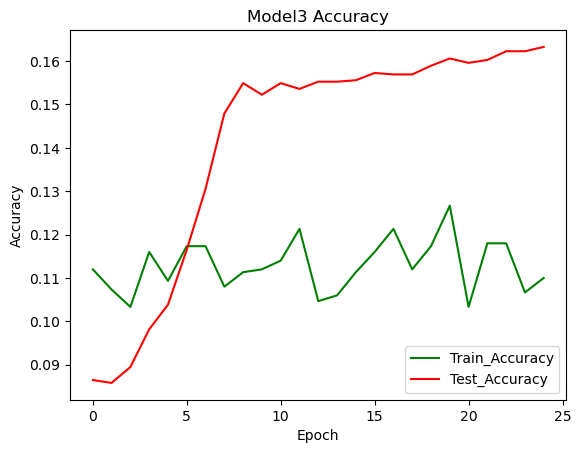

In [82]:
# Plot the model3
PLT.plot(history2.history['accuracy'],color='green')
PLT.plot(history2.history['val_accuracy'],color='red')
PLT.title('Model3 Accuracy')
PLT.ylabel('Accuracy')
PLT.xlabel('Epoch')
PLT.legend(['Train_Accuracy','Test_Accuracy'], loc='lower right')
PLT.show()